In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy.linalg as npl
np.set_printoptions(precision=2)

X = np.loadtxt("./data/MNIST5.csv", delimiter=',')
# take some of the data
X = X[:100]

In [34]:
# generate ordering set
N, M = X.shape
X -= np.mean(X) # center
D = np.array([[npl.norm(X[i]-X[j]) for i in range(N)] for j in range(N)])

imap = {} # map array index to matrix index
i = 0
d = np.array([])
for r in range(N):
    for c in range(r+1, N):
        imap[i] = (r, c)
        d = np.append(d, D[r,c])
        i += 1
        
idx = np.argsort(d)
d = d[idx]
d, unique_idx = np.unique(d, return_index=True)
idx = idx[unique_idx]
# print(d)

# compare adjacent : len(d)-1 comparisons
# S = [imap[idx[i]] + imap[idx[i+1]] for i in range(len(idx)-1)] 

# full order : len(d)C2 comparisons
S = [imap[idx[i]] + imap[idx[j]] for i in range(len(idx)) for j in range(i+1,len(idx))] 

In [35]:
# inequality constraints
A = []
for (i,j,k,l) in S:
    a = np.zeros((N,N))
    a[k,k] += 1
    a[k,l] += -2
    a[l,l] += 1
    a[i,i] += -1
    a[i,j] += 2
    a[j,j] += -1
    A.append(a)
    
# problem
K_ = cp.Variable((N,N), symmetric=True) # gram matrix
E = cp.Variable((len(S),1), nonneg=True) # slack

diff = 1 # force difference between comparisons
gamma = 0.12 # reg param for rank

constraints = []
constraints += [K_ >> 0] # PSD
constraints += [cp.sum(K_) == 0] # center
constraints += [cp.trace(A[e]@K_) >= (diff - E[e]) for e in range(len(S))]

error = cp.sum(E)
obj = cp.Minimize(error + gamma*cp.trace(K_))
prob = cp.Problem(obj, constraints)
# prob.solve()

In [36]:
%time prob.solve()

CPU times: user 4.39 s, sys: 312 ms, total: 4.7 s
Wall time: 4.43 s


/usr/local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1267: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


14.853400302500877

In [37]:
K = X@X.T
U, V = npl.eigh(K_.value)
print(npl.eigh(K)[0])
print(npl.eigh(K_.value)[0])

[  554316.83   738433.76  1058163.28  1612290.26  1938798.13  2217109.07
  2850902.    4245789.48  8393224.18 13310327.62]
[-1.82e-06 -4.15e-10  1.85e+00  2.90e+00  3.27e+00  9.43e+00  1.37e+01
  1.61e+01  2.29e+01  5.35e+01]


In [38]:
from matplotlib import offsetbox

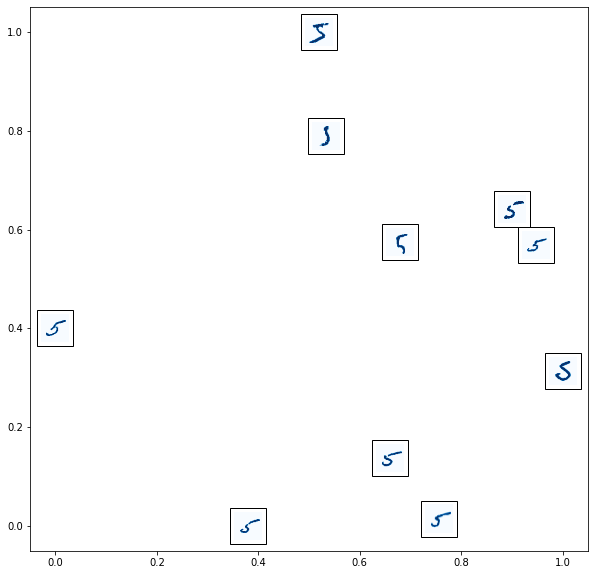

In [39]:
# plot 2-dimensional embedding
plt.figure(figsize=(10,10))
ax = plt.subplot(111)

U = U[-2:]
V = V[-2:]
X_ = (np.diag(U**0.5)@V).T

# scale
x_min, x_max = np.min(X_, 0), np.max(X_, 0)
X_ = (X_ - x_min)/(x_max - x_min)

plt.plot(X_[:,0], X_[:,1], 'C0.')

# plot representatives
shown_images = np.array([[1., 1.]]) # something big
for i in range(X_.shape[0]):
    dist = np.sum((X_[i] - shown_images)**2, 1)
    if np.min(dist) < 4e-3:
        continue # skip points that are too close
    shown_images = np.r_[shown_images, [X_[i]]]
    imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(
                    X[i].reshape(28, 28).T, cmap='Blues'), X_[i])
    ax.add_artist(imagebox)

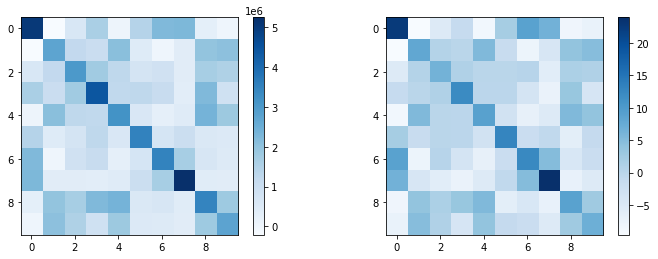

In [40]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(X@X.T, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();
plt.subplot(122)
plt.imshow(K_.value, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [41]:
# new distance matrix
D_ = np.array([[npl.norm(X_[i]-X_[j]) for i in range(N)] for j in range(N)])

# check if ordering is preserved
# based on distance matrix from positions
D_before = np.zeros(len(S))
D_after = np.zeros(len(S))

# based on gram matrix
K_before = np.zeros(len(S))
K_after = np.zeros(len(S))

for s in range(len(S)):
    (i,j,k,l) = S[s]
    D_before[s] = D[i,j] <= D[k,l]
    D_after[s] = D_[i,j] <= D_[k,l]
    K_before[s] = np.trace(A[s]@K) >= 0
    K_after[s] = np.trace(A[s]@K_.value) >= 0

# fraction of orderings preserved
D_preserved = (len(S) - np.count_nonzero(D_before-D_after))/len(S)
K_preserved = (len(S) - np.count_nonzero(K_before-K_after))/len(S)

print("%.3f"%(len(S)/(N*N-N)))
print("%.3f"%(D_preserved))
print("%.3f"%(K_preserved))

11.000
0.537
1.000
